In [1]:
using AutomotiveDrivingModels
using AutoScenes
using AutoViz
using Base.Test

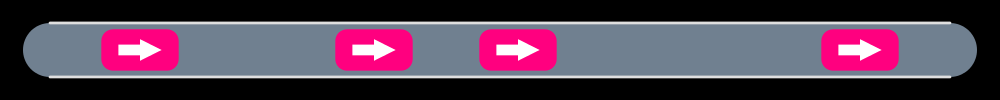

In [2]:
const Vehicle1D = Entity{PosSpeed1D, BoundingBoxDef, Int}
const Scene1D = Frame{Vehicle1D};
def = BoundingBoxDef(AgentClass.CAR, 4.0, 2.0)
roadway = Straight1DRoadway(50.0)
scene = Frame([
    Vehicle1D(PosSpeed1D(5.0,10.0), def, 1),
    Vehicle1D(PosSpeed1D(18.0,12.0), def, 2),
    Vehicle1D(PosSpeed1D(26.0,10.0), def, 3),
    Vehicle1D(PosSpeed1D(45.0, 8.0), def, 4),
])
render(scene, roadway, cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100)

We have to be careful with the $s$-coordinate to ensure independence.

### Local Parameterization
The naive local parameterization is to allow $s_2 \in [5+4, 26-4]$ and allow $s_3 \in [26+4, 45-4]$. These bounds work assuming the other position is _fixed_.

### Global Parameterization
To achieve truly valid position ranged with need one car's position to be dependent on the other car's position.
Let $\alpha_2 \in [0,1]$ and $\alpha_3 \in [0,1]$. Then we can define each car's position according to:
$$
\begin{aligned}
s_2 & = \text{lerp}(5+4, 45 - 4 - 4, \alpha_2) \\
s_3 & = \text{lerp}(s_2+4, 45 - 4, \alpha_3)
\end{aligned}
$$

Note that the position of car 1 only depends on $\alpha_2$ but the position of car two depends on both $\alpha_2$ and $\alpha_3$.

The headway is not merely a function of $\alpha_\text{fore}$:
$$
\begin{aligned}
\text{headway} & = s_\text{fore} - s_\text{rear} - 4 \\
& = \text{lerp}(s_\text{rear} + 4, b_\text{fore}, \alpha_\text{fore}) - s_\text{rear} - 4 \\
& = s_\text{rear} + 4 + \alpha_\text{fore}(b_\text{fore} - s_\text{rear} + 4)  - s_\text{rear} - 4\\
& = \alpha_\text{fore} (b_\text{fore} - s_\text{rear} + 4)
\end{aligned}
$$

Unfortunately, it requires $s_\text{rear}$, which depends on previous values of $\alpha$. As such, the headway is dependent on _all values_ of alpha up to and including $\alpha_\text{fore}$.

We _could_ get around this by having a big features but run into another problem: the features require additional information from the scene in order to back out $s$. Above, we need $b_\text{fore}$ and to get the first vehicle we need $a_1$. This is without considering vehicle lengths.

In [3]:
function AutoScenes.Vars(scene::Scene1D, roadway::Straight1DRoadway)

    n = length(scene)
    m = max(0,n-2)
    vars = Vars(Array{Float64}(m),
                Array{StateBounds}(m),
                Array{Symbol}(m),
                Array{Int}(m))

    lead_follow = LeadFollowRelationships(scene, roadway)

    # sort the s-positions from lowest to greatest
    arr_s = [veh.state.s for veh in scene]
    p = sortperm(arr_s)
    
    # introduce one variable for each moveable car
    for i in 1 : m
        
        hL_ego = scene[p[i+1]].def.len/2
        lo = arr_s[p[i]] + hL_ego + scene[p[i]].def.len/2
        hi = arr_s[p[end]] - hL_ego - scene[p[end]].def.len/2
        for j in i+2 : length(scene)-1
            hi -= scene[p[j]].def.len
        end
        α = (arr_s[p[i+1]] - lo)/(hi - lo)

        vars.values[i] = α
        vars.bounds[i] = StateBounds(-α, 1-α)
        vars.symbols[i] = :α
        vars.vehicle_indices[i] = p[i+1]
        @assert vars.bounds[i].Δlo ≤ 0.0
        @assert vars.bounds[i].Δhi ≥ 0.0
    end

    return vars
end

vars = Vars(scene, roadway)
@test length(vars) == 2
@test isapprox(lerp(5+4, 45-4-4, vars.values[1]), scene[2].state.s)
@test isapprox(lerp(scene[2].state.s + 4, 45-4, vars.values[2]), scene[3].state.s)

Test Passed


### Penalty Parameterization

We can avoid the large joint distribution by allowing each vehicle to range between its maximal values:
$$
\begin{aligned}
s_2 & \in [5+4, 45 - 4 - 4] \\
s_3 & \in [5+4+4, 45 - 4]
\end{aligned}
$$
Of course, this can lead to invalid positions. These are 'fixed' by including an additional penalty feature:
$$
f_\text{penalty}(s_2, s_3) = s_2 + 4 > s_3 \qquad \theta_\text{penalty} = -\infty
$$

The penalty feature causes $\log\tilde{p}$ to be $\infty$, and thus $\tilde{p} = 0$ whenever this occurs.

In [4]:
function AutoScenes.Vars(scene::Scene1D, roadway::Straight1DRoadway)

    n = length(scene)
    vars = Vars(Array{Float64}(n),
                Array{StateBounds}(n),
                Array{Symbol}(n),
                Array{Int}(n))

    # sort the s-positions from lowest to greatest
    arr_s = [veh.state.s for veh in scene]
    p = sortperm(arr_s)
    
    # introduce one variable for each car
    # moveable cars have bounds with positive volume
    for i in 1 : n
        
        vars.values[i] = arr_s[i]
        vars.symbols[i] = :s
        vars.vehicle_indices[i] = p[i]
        
        if i == 1
            # first car has static s
            vars.bounds[i] = ZERO_BOUND
        elseif i < n
        
            hL_ego = scene[p[i]].def.len/2
            lo = arr_s[p[1]] + hL_ego + scene[p[1]].def.len/2
            for j in 2 : i-1
                lo += scene[p[j]].def.len
            end

            hi = arr_s[p[end]] - hL_ego - scene[p[end]].def.len/2
            for j in i+1 : length(scene)-1
                hi -= scene[p[j]].def.len
            end

            s = arr_s[p[i]]

            vars.bounds[i] = StateBounds(lo-s, hi-s)
        else
            # last car has static s
            vars.bounds[i] = ZERO_BOUND
        end
        @assert vars.bounds[i].Δlo ≤ 0.0
        @assert vars.bounds[i].Δhi ≥ 0.0
    end

    return vars
end

In [5]:
vars = Vars(scene, roadway)
@test length(vars) == 4
for (i, veh) in enumerate(scene)
    @test vars.values[i] ≈ scene[i].state.s
end

@test vars.bounds[1] == ZERO_BOUND
@test vars.bounds[2].Δlo ≈ 5 + 4 - scene[2].state.s
@test vars.bounds[2].Δhi ≈ 45 - 4 - 4 - scene[2].state.s
@test vars.bounds[3].Δlo ≈ 5 + 4 + 4 - scene[3].state.s
@test vars.bounds[3].Δhi ≈ 45 - 4 - scene[3].state.s
@test vars.bounds[4] == ZERO_BOUND

Test Passed


In [6]:
function f_penalty{R}(
     vars::Vars,
     assignment::Assignment,
     roadway::R,
     )
     
     s_lo = vars.values[assignment[1]]
     s_hi = vars.values[assignment[2]]
     return s_lo + 4 > s_hi # true if in violation
end
function AutoScenes.assign_feature{F <: typeof(f_penalty)}(
    f::F,
    scene::Scene1D,
    roadway::Straight1DRoadway,
    vars::Vars,
    )
    
    lead_follow = LeadFollowRelationships(scene, roadway)

    assignments = Assignment[]
    for (vehicle_index, index_fore) in enumerate(lead_follow.index_fore)
        if index_fore != 0
            j_rear = findfirst(vars, vehicle_index, :s)
            j_fore = findfirst(vars, index_fore, :s)
            push!(assignments, (j_rear, j_fore))
        end
    end

    return assignments
end

In [7]:
function f_headway{R}(
    vars::Vars, # all variables
    assignment::Assignment, # indeces of variables in vars
    roadway::R,
    )
    
    s_lo = vars.values[assignment[1]]
    s_hi = vars.values[assignment[2]]
    Δs = s_hi - s_lo - 4
    return log(max(Δs + 1, 1.0))
end
function AutoScenes.assign_feature{F <: typeof(f_headway)}(
    f::F,
    scene::Scene1D,
    roadway::Straight1DRoadway,
    vars::Vars,
    )

    lead_follow = LeadFollowRelationships(scene, roadway)

    assignments = Assignment[]
    for (vehicle_index, index_fore) in enumerate(lead_follow.index_fore)
        if index_fore != 0
            j_rear = findfirst(vars, vehicle_index, :s)
            j_fore = findfirst(vars, index_fore, :s)
            push!(assignments, (j_rear, j_fore))
        end
    end

    return assignments
end

In [8]:
features = (f_headway,f_penalty)
factorgraph = FactorGraph(features, scene, roadway)

AutoScenes.FactorGraph{AutomotiveDrivingModels.Straight1DRoadway}(AutoScenes.Vars([5.0, 18.0, 26.0, 45.0], AutoScenes.StateBounds[AutoScenes.StateBounds(0.0, 0.0), AutoScenes.StateBounds(-9.0, 19.0), AutoScenes.StateBounds(-13.0, 15.0), AutoScenes.StateBounds(0.0, 0.0)], Symbol[:s, :s, :s, :s], [1, 2, 3, 4]), Tuple{Int64,Tuple{Vararg{Int64,N} where N}}[(1, (1, 2)), (1, (2, 3)), (1, (3, 4)), (2, (1, 2)), (2, (2, 3)), (2, (3, 4))], Array{Int64,1}[[1, 4], [1, 2, 4, 5], [2, 3, 5, 6], [3, 6]], AutomotiveDrivingModels.Straight1DRoadway(50.0))

In [9]:
θ = [1.0,-Inf]
model = FactorModel(features, θ)
gen = FactorGraphSceneGenerator(model, Dict(:s => Normal(0.0,5.0)), 100)

FactorGraphSceneGenerator(burnin=100)

In [10]:
a = zeros(length(factorgraph.vars))
b = zeros(length(factorgraph.vars))
logPtilde_a = begin
    factorgraph.vars.values .+= a
    logPtilde_a = log_ptilde(gen.model.features, gen.model.weights, factorgraph.vars,
        factorgraph.assignments, factorgraph.roadway)
    factorgraph.vars.values .-= a
    logPtilde_a
end

srand(1)
(a, logPtilde_a) = metropolis_hastings_step!(gen, factorgraph, a, b, logPtilde_a)

([0.0, 1.48644, 1.91198, 0.0], 6.777609422965663)

In [11]:
srand(0)
Δ = metropolis_hastings!(gen, factorgraph)

4-element Array{Float64,1}:
  0.0    
 -2.71295
  5.7567 
  0.0    

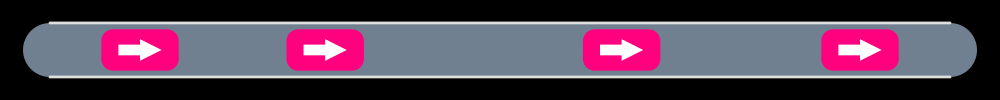

In [12]:
scene2 = Frame([
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[1] + Δ[1], 0.0), def, 1),
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[2] + Δ[2], 0.0), def, 2),
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[3] + Δ[3], 0.0), def, 3),
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[4] + Δ[4], 0.0), def, 4),
])
render(scene2, Straight1DRoadway(50.0), cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100)

# Adding length to the Scene

In the above cells we have assumed that all vehicles have the same length, and the value 4 was hard-coded into the features. We can include this length as a feature in the scene, or better yet, include the length of each vehicle.

This further gives us the option of sampling vehicle lengths, though we do not have to do that.

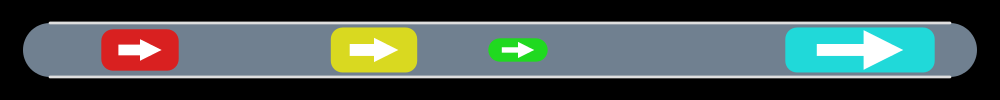

In [13]:
scene = Frame([
    Vehicle1D(PosSpeed1D(5.0,10.0), BoundingBoxDef(AgentClass.CAR, 4.0, 2.0), 1),
    Vehicle1D(PosSpeed1D(18.0,12.0), BoundingBoxDef(AgentClass.CAR, 4.5, 2.2), 2),
    Vehicle1D(PosSpeed1D(26.0,10.0), BoundingBoxDef(AgentClass.CAR, 3.0, 1.0), 3),
    Vehicle1D(PosSpeed1D(45.0, 8.0), BoundingBoxDef(AgentClass.CAR, 8.0, 2.2), 4),
])
colors = get_pastel_car_colors(scene)
render(scene, roadway, cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100, car_colors=colors)

Each factor graph will now $2n$ variables: the position and length of each car.
The bounds for the length will be zero.

In [14]:
function AutoScenes.Vars(scene::Scene1D, roadway::Straight1DRoadway)

    n = length(scene)
    vars = Vars(Array{Float64}(2n),
                Array{StateBounds}(2n),
                Array{Symbol}(2n),
                Array{Int}(2n))

    # sort the s-positions from lowest to greatest
    arr_s = [veh.state.s for veh in scene]
    p = sortperm(arr_s)
    
    # introduce the pos of each car
    # moveable cars have bounds with positive volume
    for i in 1 : n
        
        vars.values[i] = arr_s[i]
        vars.symbols[i] = :s
        vars.vehicle_indices[i] = p[i]
        
        if i == 1
            # first car has static s
            vars.bounds[i] = ZERO_BOUND
        elseif i < n
        
            hL_ego = scene[p[i]].def.len/2
            lo = arr_s[p[1]] + hL_ego + scene[p[1]].def.len/2
            for j in 2 : i-1
                lo += scene[p[j]].def.len
            end

            hi = arr_s[p[end]] - hL_ego - scene[p[end]].def.len/2
            for j in i+1 : length(scene)-1
                hi -= scene[p[j]].def.len
            end

            s = arr_s[p[i]]

            vars.bounds[i] = StateBounds(lo-s, hi-s)
        else
            # last car has static s
            vars.bounds[i] = ZERO_BOUND
        end
        @assert vars.bounds[i].Δlo ≤ 0.0
        @assert vars.bounds[i].Δhi ≥ 0.0
    end
    
    # introduce the length of each car
    for i in 1 : n
        b = i+n
        vars.values[b] = scene[p[i]].def.len
        vars.symbols[b] = :l
        vars.vehicle_indices[b] = p[i]
        vars.bounds[b] = ZERO_BOUND
    end

    return vars
end

In [15]:
vars = Vars(scene, roadway)
@test length(vars) == 8
for (i, veh) in enumerate(scene)
    @test vars.values[i] ≈ scene[i].state.s
    @test vars.values[i+length(scene)] == scene[i].def.len
    @test vars.bounds[i+length(scene)] == ZERO_BOUND
end

@test vars.bounds[1] == ZERO_BOUND
@test vars.bounds[2].Δlo ≈ 5 + 4/2 + 4.5/2 - scene[2].state.s
@test vars.bounds[2].Δhi ≈ 45 - 3 - 8/2 - 4.5/2 - scene[2].state.s
@test vars.bounds[3].Δlo ≈ 5 + 4/2 + 4.5 + 3/2 - scene[3].state.s
@test vars.bounds[3].Δhi ≈ 45 - 3/2 - 8/2 - scene[3].state.s
@test vars.bounds[4] == ZERO_BOUND

Test Passed


We modify the penalty function and the headway function to use the length.

In [16]:
function f_penalty2{R}(
     vars::Vars,
     assignment::Assignment,
     roadway::R,
     )
     
     s_lo = vars.values[assignment[1]]
     s_hi = vars.values[assignment[2]]
     l_lo = vars.values[assignment[3]]
     l_hi = vars.values[assignment[4]]
     return s_lo + (l_lo + l_hi)/2 > s_hi # true if in violation
end
function AutoScenes.assign_feature{F <: typeof(f_penalty2)}(
    f::F,
    scene::Scene1D,
    roadway::Straight1DRoadway,
    vars::Vars,
    )
    
    lead_follow = LeadFollowRelationships(scene, roadway)

    assignments = Assignment[]
    for (vehicle_index, index_fore) in enumerate(lead_follow.index_fore)
        if index_fore != 0
            j_rear_s = findfirst(vars, vehicle_index, :s)
            j_fore_s = findfirst(vars, index_fore, :s)
            j_rear_l = findfirst(vars, vehicle_index, :l)
            j_fore_l = findfirst(vars, index_fore, :l)
            push!(assignments, (j_rear_s, j_fore_s, j_rear_l, j_fore_l))
        end
    end

    return assignments
end

In [17]:
function f_headway2{R}(
    vars::Vars, # all variables
    assignment::Assignment, # indeces of variables in vars
    roadway::R,
    )
    
    s_lo = vars.values[assignment[1]]
    s_hi = vars.values[assignment[2]]
    l_lo = vars.values[assignment[3]]
    l_hi = vars.values[assignment[4]]
    Δs = s_hi - s_lo - (l_lo + l_hi)/2
    return log(max(Δs + 1, 1.0))
end
function AutoScenes.assign_feature{F <: typeof(f_headway2)}(
    f::F,
    scene::Scene1D,
    roadway::Straight1DRoadway,
    vars::Vars,
    )

    lead_follow = LeadFollowRelationships(scene, roadway)

    assignments = Assignment[]
    for (vehicle_index, index_fore) in enumerate(lead_follow.index_fore)
        if index_fore != 0
            j_rear_s = findfirst(vars, vehicle_index, :s)
            j_fore_s = findfirst(vars, index_fore, :s)
            j_rear_l = findfirst(vars, vehicle_index, :l)
            j_fore_l = findfirst(vars, index_fore, :l)
            push!(assignments, (j_rear_s, j_fore_s, j_rear_l, j_fore_l))
        end
    end

    return assignments
end

Note that since l always has a zero bound we do not need to specify a transition distribution for it.

In [18]:
features = (f_headway2,f_penalty2)
factorgraph = FactorGraph(features, scene, roadway)
θ = [1.0,-Inf]
model = FactorModel(features, θ)
gen = FactorGraphSceneGenerator(model, Dict(:s => Normal(0.0,5.0)), 100)

FactorGraphSceneGenerator(burnin=100)

In [19]:
a = zeros(length(factorgraph.vars))
b = zeros(length(factorgraph.vars))
logPtilde_a = begin
    factorgraph.vars.values .+= a
    logPtilde_a = log_ptilde(gen.model.features, gen.model.weights, factorgraph.vars,
        factorgraph.assignments, factorgraph.roadway)
    factorgraph.vars.values .-= a
    logPtilde_a
end

srand(0)
(a, logPtilde_a) = metropolis_hastings_step!(gen, factorgraph, a, b, logPtilde_a)

([0.0, 3.39554, 4.14207, 0.0, 0.0, 0.0, 0.0, 0.0], 6.705015994828035)

In [20]:
srand(0)
Δ = metropolis_hastings!(gen, factorgraph)

8-element Array{Float64,1}:
 0.0     
 1.10369 
 0.506497
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     

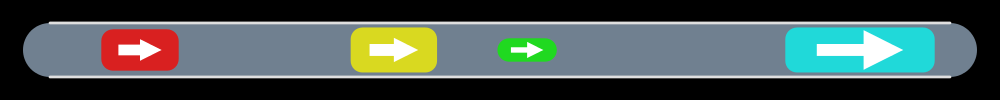

In [21]:
scene2 = Frame([
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[1] + Δ[1], 0.0), scene[1].def, 1),
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[2] + Δ[2], 0.0), scene[2].def, 2),
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[3] + Δ[3], 0.0), scene[3].def, 3),
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[4] + Δ[4], 0.0), scene[4].def, 4),
])
render(scene2, roadway, cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100, car_colors=colors)

# Wraparound

Finally, we handle wraparound, which is where the road loops back on itself.
In this case we can no longer have the static end cars to anchor the scenem, but can move all vehicles from at $s \pm L/2$.

We must still preserve ordering. For a 1D scene with cars 1 following 2 following 3 ... following n following 1 it is sufficient to enforce $\text{ceil}(n/2)$ relationships:

$$
(1 < 2 < 3) \quad (3 < 4 < 5) \enspace \cdots \enspace (m-1 <  m < 1)
$$

or 

$$
(1 < 2 < 3) \quad (3 < 4 < 5) \enspace \cdots \enspace (m < 1 < 2)
$$

where $i < j < k$ indicates indicates that vehicle $j$ is between $i$ and $k$, as checked by verifying that the $ij$ headway is less than the $ik$ headway.

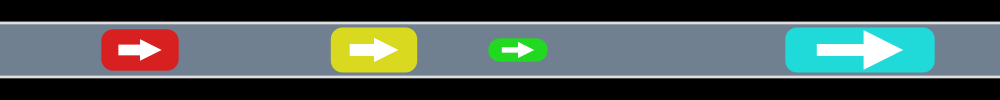

In [22]:
roadway = Wraparound(Straight1DRoadway(50.0))
render(scene, roadway, cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100, car_colors=colors)

The position bounds in the factorgraph are now $\pm L/2$ for all vehicles.

In [23]:
function AutoScenes.Vars(scene::Scene1D, roadway::Wraparound{Straight1DRoadway})

    n = length(scene)
    vars = Vars(Array{Float64}(2n),
                Array{StateBounds}(2n),
                Array{Symbol}(2n),
                Array{Int}(2n))
    
    L = get_s_max(roadway)
    
    b = 0
    for (vehicle_index, veh) in enumerate(scene)
        
        # position
        b += 1
        vars.values[b] = veh.state.s
        vars.bounds[b] = StateBounds(-L/2, L/2)
        vars.symbols[b] = :s
        vars.vehicle_indices[b] = vehicle_index
        
        # length
        b += 1
        vars.values[b] = veh.def.len
        vars.symbols[b] = :l
        vars.vehicle_indices[b] = vehicle_index
        vars.bounds[b] = ZERO_BOUND
    end

    return vars
end

In [24]:
vars = Vars(scene, roadway)
@test length(vars) == 8
for (i, veh) in enumerate(scene)
    @test vars.values[2i-1] ≈ scene[i].state.s
    @test vars.bounds[2i-1] == StateBounds(-25.0,25.0)
    @test vars.values[2i] == scene[i].def.len
    @test vars.bounds[2i] == ZERO_BOUND
end

We construct the penalty function and assign it as appropriate.

In [65]:
function f_penalty3(
    vars::Vars,
    assignment::Assignment,
    roadway::Wraparound{Straight1DRoadway},
    )
     
    # a < b < c
    
    sa = vars.values[assignment[1]]
    sb = vars.values[assignment[2]]
    sc = vars.values[assignment[3]]
    la = vars.values[assignment[4]]
    lb = vars.values[assignment[5]]
    lc = vars.values[assignment[6]]
     
    # true if in violation
    
    vehA = Vehicle1D(PosSpeed1D(sa, NaN), BoundingBoxDef(AgentClass.CAR, la, NaN), 1)
    vehB = Vehicle1D(PosSpeed1D(sb, NaN), BoundingBoxDef(AgentClass.CAR, lb, NaN), 1)
    vehC = Vehicle1D(PosSpeed1D(sc, NaN), BoundingBoxDef(AgentClass.CAR, lc, NaN), 1)
    
    ab = get_headway(vehA, vehB, roadway)
    ac = get_headway(vehA, vehC, roadway)
    return ac < ab || is_colliding(vehA, vehB, roadway) || 
                      is_colliding(vehA, vehC, roadway) || 
                      is_colliding(vehB, vehC, roadway)
end
function AutoScenes.assign_feature{F <: typeof(f_penalty3)}(
    f::F,
    scene::Scene1D,
    roadway::Wraparound{Straight1DRoadway},
    vars::Vars,
    )
    
    lead_follow = LeadFollowRelationships(scene, roadway)

    assignments = Assignment[]
    for i in 1 : 2 : length(scene)
        j = lead_follow.index_fore[i]
        k = lead_follow.index_fore[j]
        
        push!(assignments, (findfirst(vars, i, :s), findfirst(vars, j, :s), findfirst(vars, k, :s),
                            findfirst(vars, i, :l), findfirst(vars, j, :l), findfirst(vars, k, :l)))
    end

    return assignments
end

In [66]:
function f_headway3(
    vars::Vars,
    assignment::Assignment,
    roadway::Wraparound{Straight1DRoadway},
    )
     
    # a < b
    
    sa = vars.values[assignment[1]]
    sb = vars.values[assignment[2]]
    la = vars.values[assignment[3]]
    lb = vars.values[assignment[4]]
    
    vehA = Vehicle1D(PosSpeed1D(sa, NaN), BoundingBoxDef(AgentClass.CAR, la, NaN), 1)
    vehB = Vehicle1D(PosSpeed1D(sb, NaN), BoundingBoxDef(AgentClass.CAR, lb, NaN), 1)
    ab = get_headway(vehA, vehB, roadway)
    return log(ab + 1)
end
function AutoScenes.assign_feature{F <: typeof(f_headway3)}(
    f::F,
    scene::Scene1D,
    roadway::Wraparound{Straight1DRoadway},
    vars::Vars,
    )
    
    lead_follow = LeadFollowRelationships(scene, roadway)

    assignments = Assignment[]
    for i in 1 : length(scene)
        j = lead_follow.index_fore[i]
        
        push!(assignments, (findfirst(vars, i, :s), findfirst(vars, j, :s),
                            findfirst(vars, i, :l), findfirst(vars, j, :l)))
    end

    return assignments
end

In [67]:
features = (f_headway3,f_penalty3)
factorgraph = FactorGraph(features, scene, roadway)
θ = [1.0,-Inf]
model = FactorModel(features, θ)
gen = FactorGraphSceneGenerator(model, Dict(:s => Normal(0.0,5.0)), 100)

FactorGraphSceneGenerator(burnin=100)

In [70]:
a = zeros(length(factorgraph.vars))
b = zeros(length(factorgraph.vars))
logPtilde_a = begin
    factorgraph.vars.values .+= a
    logPtilde_a = log_ptilde(gen.model.features, gen.model.weights, factorgraph.vars,
        factorgraph.assignments, factorgraph.roadway)
    factorgraph.vars.values .-= a
    logPtilde_a
end

srand(2)
(a, logPtilde_a) = metropolis_hastings_step!(gen, factorgraph, a, b, logPtilde_a)

([3.6981, 0.0, -3.72254, 0.0, -3.04254, 0.0, -8.61728, 0.0], 7.666098276964196)

In [98]:
srand(0)
Δ = metropolis_hastings!(gen, factorgraph)

8-element Array{Float64,1}:
 -10.2643 
   0.0    
  -9.47718
   0.0    
 -11.4644 
   0.0    
 -11.2033 
   0.0    

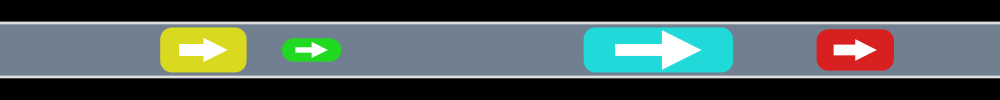

In [100]:
scene2 = Frame([
    Vehicle1D(PosSpeed1D(mod_position_to_roadway(factorgraph.vars.values[1] + Δ[1], roadway), 0.0), scene[1].def, 1),
    Vehicle1D(PosSpeed1D(mod_position_to_roadway(factorgraph.vars.values[3] + Δ[3], roadway), 0.0), scene[2].def, 2),
    Vehicle1D(PosSpeed1D(mod_position_to_roadway(factorgraph.vars.values[5] + Δ[5], roadway), 0.0), scene[3].def, 3),
    Vehicle1D(PosSpeed1D(mod_position_to_roadway(factorgraph.vars.values[7] + Δ[7], roadway), 0.0), scene[4].def, 4),
])
render(scene2, roadway, cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100, car_colors=colors)